# Gold Price 

This project looks at building the infrastructure to visualise the recent movements in gold prices while building out a modern data processing infrastucture.

In [168]:
import yfinance as yf
from pathlib import Path
import pandas as pd
from datetime import datetime

This simulates the equivalent of having an AWS S3 or Azure Data Lake Storage.

In [169]:
data_lake_path = Path.cwd() / 'data-lake'

## Yahoo Finance API

We have to define our structure and partitioning for our data. Our queries are likely going to be Yearly, Monthly, Weekly, Daily.

Storing ticker data on a monthly partition will be a good balance between the different levels of granularity.

In [170]:
ticker = 'GC=F'
start_date = datetime.strptime('2000-01-01', "%Y-%m-%d")
end_date = datetime.strptime('2025-10-25', "%Y-%m-%d")

We want to generate a list of month start and end dates so we can make a request to the yfinance API.

In [171]:
months_range = pd.date_range(start=start_date, end=end_date, freq='MS')
month_starts = [d.strftime("%Y-%m-%d") for d in months_range]

save_dir = Path(data_lake_path) / 'bronze' / ticker
save_dir.mkdir(parents=True, exist_ok=True)

data = yf.download(ticker, start=start_date, end=end_date)
data.index = pd.to_datetime(data.index).round("us")
data = data.reset_index().rename(columns={"index": "Date"})

# Yahoo Finance returns MultiIndex columns, we are just cleaning them up.
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)
    data.columns.name = None

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

save_dir = Path(data_lake_path) / 'bronze' / ticker
data.to_parquet(save_dir, engine="pyarrow", partition_cols=['Year','Month'], coerce_timestamps='us', index=False)

/var/folders/kw/nybtcrjn2g7f36mgb6lbvm_80000gn/T/ipykernel_76988/1726311112.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


## PySpark

We can use PySpark to query our data lake to perform operations on more than a month's data! 

We will also configure the spark environment to use delta.

In [172]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (
    SparkSession.builder
        .appName("GoldPriceETL")
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
        .master("local[*]")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [173]:
bronze_path = "data-lake/bronze/GC=F/"
df = spark.read.parquet(bronze_path)

Typically you would not load the entire dataset into memory without some kind of sampling for big data, but because our dataset is small we can do this and plot directly.

In [174]:
pdf = df.toPandas()

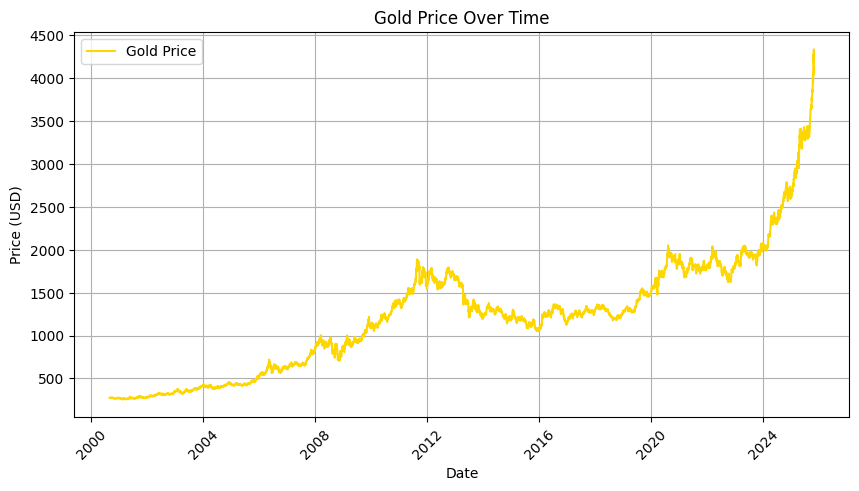

In [175]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

pdf = pdf.sort_values('Date').reset_index(drop=True) # ensure data is sorted by date

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pdf['Date'], pdf['Close'], label='Gold Price', color='gold')
ax.set_title('Gold Price Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
plt.xticks(rotation=45)
ax.legend()
plt.grid()
plt.show()